In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#from preprocess import train_test_seq#, scale_df
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-4): 
    # Avoid values too close to zero
    idxs = np.abs(y_true) > eps
    return np.mean(np.abs((y_true[idxs] - y_pred[idxs]) / y_true[idxs])) * 100 
#if y_true != 0 else 0.0

In [4]:
mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

In [5]:
def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")

In [6]:
# Load in the time series
candy = pd.read_csv('candy_production.csv', 
            index_col='date',
            parse_dates=True)
candy.head()

,IPG3113N
date,
1972-01-01,85.598809
1972-02-01,71.741404
1972-03-01,65.948809
1972-04-01,64.490724
1972-05-01,64.933842


In [7]:
candy.shape

(564, 1)

## Train/Test split

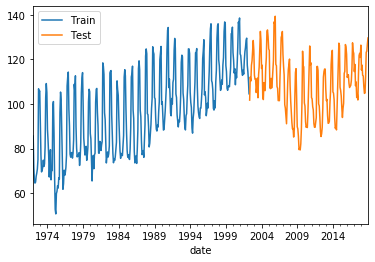

In [8]:
# Split the data into a train and test set
#df_train, df_test = candy.iloc[:-250], candy.iloc[-250:]
df_train, df_test = candy.iloc[:-200], candy.iloc[-200:]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test setsa dn show
df_train.plot(ax=ax)
df_test.plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
plt.show()

Univariate forecasting requires using the same sequence as features and target. Here is one choice where I do not use the test dataframe.

**Features**: 0-100 time points

**Target**  : 100-200 time points

In [9]:
X_train = df_train[-300:-200].to_numpy().reshape(-1,1)
X_test  = df_train[-200:-100].to_numpy().reshape(-1,1)

y_train = df_train[-200:-100].to_numpy().ravel()
y_test  = df_train[-100:].to_numpy().ravel() 

#X_train = df_train[-200:-100].to_numpy().reshape(-1,1)
#X_test  = df_test[-100:-50].to_numpy().reshape(-1,1)

#y_train = df_train[-200:-100].to_numpy().ravel()
#y_test  = df_test[-100:-50].to_numpy().ravel() 

## Baseline

### 1. Last value

In [10]:
y_base1 = np.copy(y_test)
y_base1[:] = y_test[0]

In [11]:
print_scores(y_test, y_base1)

R2 score: -0.44501992071288243
MSE score: 228.26728138975366
MAE score: 12.076231907505443
MAPE score: 10.114830034905106
Median AE score: 9.37603926045103


### 2. Rolling mean

In [12]:
candy_rolling_mean = candy.rolling(20).mean()

y_base2 = candy_rolling_mean.iloc[-100:].to_numpy()

In [13]:
print_scores(y_test, y_base2)

R2 score: -0.298747826933458
MSE score: 205.1609333653304
MAE score: 10.642681908653898
MAPE score: 10.620370484183471
Median AE score: 7.633135193490908


## Pipeline

In [14]:
pipe_lasso = Pipeline([
                       #('scale', MinMaxScaler(feature_range=(0, 1))),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso())
                       ])

pipe_rf = Pipeline([
                    #('scale', MinMaxScaler(feature_range=(0, 1))),
                    ('scale', StandardScaler()),
                    ('rf', RandomForestRegressor(random_state=42))
                    ])

In [15]:
params_lasso = {'lasso__alpha': np.logspace(-4,1,10)}
              
params_rf = {
             #'rf__criterion': ['mae', 'mse'],
             'rf__max_depth': [2, 4, 8],
             #'rf__max_features': ['auto', 'sqrt', None],
             'rf__min_samples_leaf': [2, 4, 8],
             'rf__n_estimators': [8, 16, 32, 64]
            }

## GridSearchCV

### LASSO

In [16]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gs_lasso = GridSearchCV(pipe_lasso,
                        param_grid=params_lasso,
                        scoring='neg_mean_absolute_error',
                        cv=my_cv,
                        n_jobs=4) 

In [17]:
# Fit to the training set
gs_lasso.fit(X_train,y_train)

# Predict
y_pred_lasso = gs_lasso.predict(X_test)

# Compute and print the metrics
print(f"Tuned Lasso Alpha: {gs_lasso.best_params_}")
print(f"Tuned Lasso Score: {gs_lasso.score(X_test, y_test)}")

Tuned Lasso Alpha: {'lasso__alpha': 2.782559402207126}
Tuned Lasso Score: -17.29391429915223


In [18]:
print_scores(y_test, y_pred_lasso)

R2 score: -1.6596253138861394
MSE score: 420.13638096881834
MAE score: 17.29391429915223
MAPE score: 14.43984346357555
Median AE score: 16.92541778766853


### Random Forests

In [19]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=params_rf,
                     scoring='neg_mean_absolute_error',
                     cv=my_cv, 
                     n_jobs=4)

In [20]:
# Fit to the training set
gs_rf.fit(X_train,y_train)

# Predict
y_pred_rf = gs_rf.predict(X_test)

# Compute and print the metrics
print(f"Tuned RF params: {gs_rf.best_params_}")
print(f"Tuned RF Score:  {gs_rf.score(X_test, y_test)}")

Tuned RF params: {'rf__max_depth': 2, 'rf__min_samples_leaf': 8, 'rf__n_estimators': 16}
Tuned RF Score:  -19.740117799280988


In [21]:
print_scores(y_test, y_pred_rf)

R2 score: -2.4912056251799735
MSE score: 551.4996751320172
MAE score: 19.740117799280988
MAPE score: 16.456281090024376
Median AE score: 17.706203309761726


## Plot `y_pred`

In [22]:
y_pred_lasso.shape, y_pred_rf.shape

((100,), (100,))

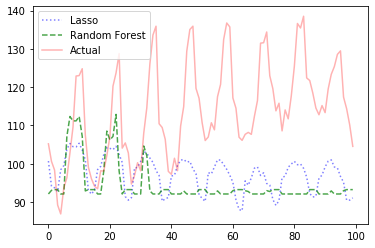

In [23]:
#t_test = np.linspace(4000, 4000+tst_sz, tst_sz)

plt.plot(y_pred_lasso, 'b:', label='Lasso', alpha=0.5)
plt.plot(y_pred_rf, 'g--', label='Random Forest', alpha=0.7)
plt.plot(y_test, 'r', label='Actual', alpha=0.3)
#plt.plot(y_base1, 'k-.', label='Base1', alpha=0.3)
#plt.plot(y_base2, 'k-.', label='Base2', alpha=0.4)
plt.legend()

**Conclusion** (MAPE scores): Lasso (14), RF (16) are struggling to do better than baseline scores of 10. The first 20 or so forecasting steps are doing relatively better but the longer evolution is hard to predict.